In [764]:
import numpy as np
from numpy.linalg import matrix_rank
from numpy.linalg import inv

import scipy 
import scipy.stats as stats
from scipy.special import softmax, logit, expit
from scipy.linalg import eigh
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [530]:
class DiGraph(Graph):
    def __init__(self):
        super(DiGraph, self).__init__()
        
    def add_edge(self, in_node, out_node, *edge_dict):
        edge = (in_node, out_node)
        if (out_node, in_node) in self.edges:
            raise ValueError(f"Edge {edge} can't be added. Edge in opposite direction already exists!")
        if not in_node in self.nodes or not out_node in self.nodes:
            missing_nodes = [node for node in edge if not(node in self.nodes)]
            raise ValueError(f"Edge {edge} can't be added. The graph does not contain the following nodes: {missing_nodes}")
        self.edges[edge] = Edge(self, edge, edge_dict[0]) if edge_dict else Edge(self, edge)

In [1456]:
class Graph(object):
    def __init__(self):
        self.edges = dict()
        self.nodes = dict()

        
    def adjacency_matrix(self, weight = None):
        N = len(self.nodes)
        A = np.zeros((N,N))
        
        for (i,j), edge_data in self.edges.items():
            A[i-1, j-1] = 1 if weight == None else edge_data.edge_dict['weight']
        return A
    
    def degree_matrix(self):
        return np.diag([degree for node, degree in self.degree.items()])
    
    def laplacian_matrix(self):
        D = self.degree_matrix()
        W = self.adjacency_matrix()
        L = D - W
        return L
    
    def normalized_laplacian_matrix(self):
        D = self.degree_matrix()
        D_neg_2 = sqrtm(inv(D))
        L = self.laplacian_matrix()
        L_sym = D_neg_2 @ L @ D_neg_2
        return L_sym 
    
    @property
    def degree(self):
        return {node: node_data.degree() for (node, node_data) in self.nodes.items()}
        
    def number_of_nodes(self):
        return len(self.nodes)
    
    def number_of_edges(self):
        return len(self.edges)
        
    def add_node(self, node = None):
        if node == None:
            node = max(self.nodes.keys())+1
        self.nodes[node] = Node(self, node)
        
    def add_edge(self, out_node, in_node, *edge_dict):
        edge = (out_node, in_node)
        reverse_edge = (in_node, out_node)
        
        if not in_node in self.nodes or not out_node in self.nodes:
            missing_nodes = [node for node in edge if not(node in self.nodes)]
            raise ValueError(f"Edge {edge} can't be added. The graph does not contain the following nodes: {missing_nodes}")
        
        self.edges[edge] = Edge(self, edge, edge_dict[0]) if edge_dict else Edge(self, edge)
        self.edges[reverse_edge] = Edge(self, reverse_edge, edge_dict[0]) if edge_dict else Edge(self, reverse_edge)   
        
    def add_nodes_from(self, nodes):
        for node in nodes:
            self.add_node(node)
            
    def add_edges_from(self, edges):
        for edge in edges:
            self.add_edge(*edge)
            
    def remove_edge_permutations(self):        
        for edge in self.edges:
            double_edge = (edge[1], edge[0])
            if double_edge in self.edges:
                self.edges.pop(double_edge)
                return self.remove_edge_permutations()

    def connect_nodes(self, out_nodes = None, in_nodes = None): 
        if out_nodes == None:
            out_nodes = range(1, len(self.nodes) + 1)
        if in_nodes == None:
            in_nodes = range(1, len(self.nodes) + 1)
        self.edges.update({(i,j):Edge(self,(i,j)) for i in out_nodes for j in in_nodes if i != j})

In [538]:
class Edge(object):
    def __init__(self, graph, edge, *edge_dict):
        self.graph = graph
        
        (out_node,
         in_node) = edge
        
        self.edge_dict = edge_dict[0] if edge_dict else {}
        self.out_node = graph.nodes[out_node]
        self.in_node = graph.nodes[in_node]
    

In [604]:
class Node(object):
    def __init__(self, graph, node):
        self.graph = graph
        self.id = node
        
    def degree(self):
        return int(len([True for edge in self.graph.edges if self.id in edge])/2)

In [1469]:
def k_eigs(A, K = None, smallest = True, coverage = 0.9):
    eigs =list()
    V = list()
    
    if smallest:
        eig_max,_ = power_iteration(A)
        I = np.eye(len(A))
        A = A - eig_max *I
        eig_sum = np.abs(np.trace(A))
        
    if K == None:
        k_eig_sum = 0
        while k_eig_sum < eig_sum * coverage:
            eig, v = power_iteration(A)
            eigs.append(eig)
            V.append(v)
            A = A - eig * v @ v.T
            k_eig_sum = np.abs(np.array(eigs).sum())
    else:
        for k in range(K):
            eig, v = power_iteration(A)
            eigs.append(eig)
            V.append(v)
            A = A - eig * v @ v.T
    
    eigs = np.array(eigs)
    if smallest:
        eigs += eig_max
    V = np.concatenate(V, axis = 1)
    return eigs, V

In [1156]:
def power_iteration(A, num_iter = 25):
    # get eigenvector
    v = nr.random(size = (len(A), 1)) 
    v = v / v.sum()
    for i in range(num_iter):
        v = A @ v
        v = v / np.linalg.norm(v)
        
    # get eigenvalue  
    eig = (v.T @ A @ v).squeeze()
    return eig, v

In [1303]:
def create_clustered_graph(K, N):
    """
    Arguments
    ---------
    K : int
        number of clusters
    N : int 
        number of nodes per cluster
    Returns
    -------
    G : Graph
    """
    G = Graph()
    # create clusters
    for k in range(K):
        C_k = list()
        for i in range(1,N+1):
            node = k * N + i
            G.add_node(node)
            C_k.append(node)
        G.connect_nodes(C_k,C_k)
        
    # unite clusters with one node from each
    for k in range(K-1):
        G.add_edge(k * N + 1, (k+1) * N + 1)
    return G

In [1457]:
def cluster_graph(G, K, visualize = True):
    L = G.normalized_laplacian_matrix()
    eig,V = k_eigs(L, K = K)

    k_means = KMeans(n_clusters = K)
    k_means.fit(V)
    cluster = k_means.predict(V)
    print(f'Number of clusters:', K)
    if visualize:
        t_sne = TSNE(n_components = 2)
        t_sne.fit(V)
        V_emb = t_sne.embedding_

        for k in range(K):
            x = V_emb[cluster == k, 0]
            y = V_emb[cluster == k, 1]
            plt.scatter(x,y)
            
    return cluster

Number of clusters: 4


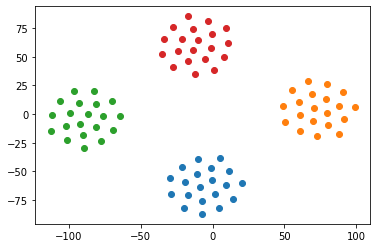

In [1472]:
K = 4
N = 20
G = create_clustered_graph(K = K, N= N)
cluster = cluster_graph(G,K = K)

In [1441]:
def remove_random_labels_from_graph(G):
    """
    Arguments
    ---------
    G : Graph
    
    Returns
    -------
    labeled : np.array [N]
        randomly created mask for which nodes in graph are labeled
    """
    labeled = np.random.randint(2, size = (len(G.nodes))) == 1
    return labeled

In [1439]:
def label_propagation(G, labeled):
    """
    Arguments
    ---------
    G : Graph
    labeled : np.array [N]
        randomly created mask for which nodes in graph are labeled
    
    Returns
    -------
    y_U : np.array [N_unseen]
        category prediction for unlabeled nodes
    """
    y = cluster_graph(G,K = 2)
    L = G.laplacian_matrix()
    
    L_SS = L[labeled][:,labeled]
    L_SU = L[labeled][:,~labeled]
    L_UU = L[~labeled][:,~labeled]
    L_US = L[~labeled][:,labeled]
    y_S = y[labeled]

    # predict
    y_U = (- inv(L_UU) @ L_US @ y_S)

    # control
    # y_U == y[~labeled]
    return y_U